# Energy Prediction Using Machine Learning Algorithms

## Index:


* ###  1. Introduction
* ###  2. Overview and data loading
* ###  3. Visualization
* ###  4. Missing values and outliers
* ###  5. Splitting of the dataset
* ###  6. Linear Regression
* ###  7. Random Forest Regressor
* ###  8. Support Vector Regression
* ###  9. Comparison of the results
* ### 10. Deployment of the model

## 1. Introduction 

In this project I show the implementation of a supervised learning procedure with the necessary pre- and post-processing steps using the case of the energy prediction of a machining process.

The transformation of the energy system towards renewable generation, increases the need to manage decentralized flexibilities more efficiently. For this, precise forecasting of uncontrollable electrical load is key. Although there is an abundance of studies presenting innovative individual methods for load forecasting, comprehensive comparisons of popular methods are hard to come across. Overall, identifying a single best method remains a challenge specific to the forecasting task.

The goal in this project is to perform a regression analysis using the data that we have to train different regression models to predict the target variable. In our use case we want to predict the energy requirement to perform a milling process.

#### 1.1 Motivation for energy prediction

1. Creation of transparency and implementation of energy planning
2. Adaptation and optimization of the process parameters according to the energy requirement
3. Possibility of load management
4. Detection of deviations due to the comparison of the prediction and the actual energy profile


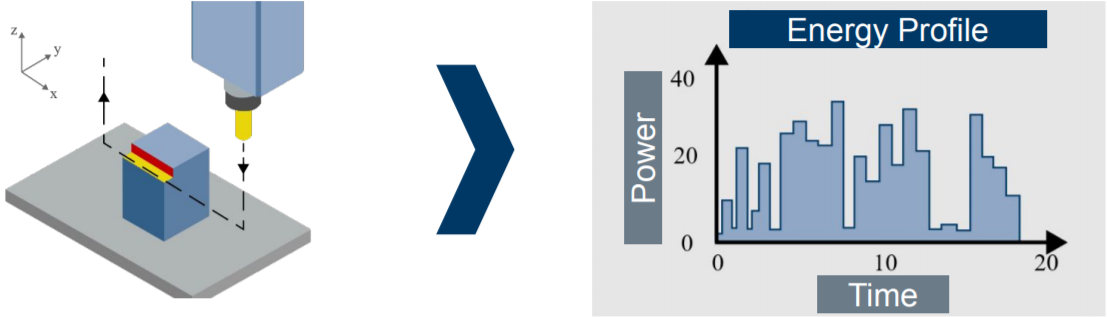

<div>
<img src="attachment:ML6.png" width="800"/>
</div>

Based on the planned process parameters, the energy required for the milling process is to be forecasted. As a basis for the development of a regression model, tests were carried out on a milling machine to gain sufficient data for the training.

#### 1.2 Structure of a milling machine

Using the Cartesian coordinate system, a machine can be controlled along each axis. Based on each axis, you typically get the following movements from the perspective of an operator facing the machine:
- X axis allows movement “left” and “right”
- Y axis allows movement “forward” and “backward”
- Z axis allows movement “up” and “down”

![millingmachine.jpeg](https://i0.wp.com/www.autodesk.com/products/fusion-360/blog/wp-content/uploads/2018/07/7-machine-axes.png?resize=450%2C393&ssl=1)

Based on these movements, the right tool and other process parameters (feed, etc.) we can perform the required milling process energy prediction.

## 2. Data loading and first overview

* The given data is stored in a text file containing the following columns,

  * Axis X, Y and Z
  * Feed [mm/min]
  * Path [mm]
  * Energy requirement - Target variable [kJ]

#### 2.1 Loading the data

First we have to load the necessary libraries. 

In [1]:
# importing the necessary libraries
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

# setting white grid background
sns.set_style('whitegrid')
#%matplotlib notebook
%matplotlib inline

The next step is to access the prepared data set and load the data.

In [ ]:
df = pd.read_csv(r'dataset_energy_measurement.txt')

#### 2.1 Overview of the data

After that we need an overview of the dataset.

In [ ]:
df.head()

First lets modify the column's titles and add the units.

In [ ]:
df.describe()

In [ ]:
df.shape #this gives us the dimensions of the dataset (rows, columns)

The method ``describe()`` gives us a quick overview of the dataset values, this can be useful for the initial phases of our pipeline. We can clearly see there are missing values in the columns Axis, Feed and Path, since the count of values does not match with the total number of data entries (226). This is most likely caused by NaN values due to a sensor malfunction or failure to collect data. Furthermore, this method also gives wide information on some basic statistics of the dataset, such as standard deviation, the mean and quartile distribution. Max and Min info are always useful to promptly identify outliers in the data and assess wether to eliminate those from the dataset. 

## 3. Visualization 

We perform a quick initial visualization of our data in order to better understand the distributions and clusters of data. This will help assessing any potential errors in data collecting.

### 3.1 Energy requirement

In [ ]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(10, 5))
sns.distplot(df["Energy_Requirement"],
             kde=True,
             kde_kws={"color": "g", "alpha": 0.3, "linewidth": 5, "shade": True})
plt.title("Energy requirement distribution")
plt.xlabel("Energy requirement (KJ)")
plt.show()

### 3.2 Path

In [ ]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(10, 5))
sns.distplot(df["Path"],
             kde=True,
             kde_kws={"color": "r", "alpha": 0.3, "linewidth": 5, "shade": True})
plt.title("Path distribution")
plt.xlabel('Path [mm]')
plt.ylabel('Total quantity')
plt.show()

### 3.3 Axis

In [ ]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(10, 5))
sns.distplot(df["Axis"],
             kde=True,
             kde_kws={"color": "y", "alpha": 0.3, "linewidth": 5, "shade": True})
plt.title("Axis distribution")
plt.xlabel('Axis')
plt.ylabel('Total quantity')
plt.show()

### 3.4 Feed

In [ ]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(10, 5))
sns.distplot(df["Feed"],
             kde=True,
             kde_kws={"color": "b", "alpha": 0.4, "linewidth": 5, "shade": True}, bins=30)
plt.title("Feed distribution")
plt.xlabel('Feed (mm/min)')
plt.ylabel('Total quantity')
plt.show()

## 4. Missing values and outliers

From the previous distributions we can determine that the `Energy requirement` data has the expected Gaussian distribution, while the rest of the columns are clustered in a different way. The `Path`data is highly clustered with barely any outliers. The `Axis` data clearly has some wrong data since the only desirable inputs should be 1 for axis X, 2 for axis Y and 3 for axis Z. The `Feed` data shows also some minor low inputs which we will exclude from the analysis since they represent a rather small percentage of the total amount of interactions, with doing so we will increase the accuracy in the predictions. 

Missing values and outliers have to be detected and dealt with in order to prepare the data set for the following steps.

#### 4.1 Handling missing values

Missing values can be NaN values or breaks in the dataset that do not seem reasonable.

In [ ]:
df.head(10)

We remove all rows with missing values

In [ ]:
df=df.dropna() 
df.head(10)

We can see that the rows 5, 6, 7 and 8 have been dropped as they contained some missing values (NaN). 

#### 4.2 Handling outliers

Before we can deal with outliers, we have to identify them. Outliers are sometimes the result of wrong data or errors in collecting it. Before deciding wether to remove an outlier or not, further inspection on both the dataset and the outlier(s) should be made. Outliers can skew data and mess up with the results(e.g. changing the relationship of a correlation of data). It is for this reason that the nature of the outliers must be understood before removing them.

Since we have performed the tests for the independent variables (feed, axis and path) we know the range of these values. 
1. Axis: 1 to 3
2. distance: -60 to 60 [mm]
3. Feed rate: 500 to 3000 [mm/min]

All values outside these ranges are therefore outliers. The relevant instances should therefore be deleted.

Values of features outside the range of the are removed and we will only include those values of the feature that lie in the particular ranges of the feature.

In [ ]:
df.describe()

In [ ]:
df = df.loc[(df.Axis >= 1) & (df.Axis <= 3) & 
            (df.Path >= -60) & (df.Path <= 60) &
            (df.Feed >= 500) & (df.Feed <= 3000)
            ]  
df.shape   

After removing the ouliers we analyze the data set again.

In [ ]:
df.describe()

We can now observe a change in the parameters of the distributions of the remaining data. The mean values have remained fairly equal for the `Axis` and `Feed` columns but it has improved considerably for the `Path` column. In terms of the standard deviation, all three have been reduced, which means the data is now more densily clustered. We have reduced the size of our dataset from 220 to 218 counts, which doesn't involve a great loss of data.

## 5. Splitting of the data set

Before we continue with the training, we have to split our data set.

1. Training dataset: the training dataset is used to determine the models parameters based on the data it has seen. Here, the labels are provided to the model so that it can learn about potential patterns in the data and thus adjust its parameters in such a way that it can predict data points.

2. Test dataset: This dataset is used to test the performance of the model. It can be used to see if the model is able to perform well on data which it has never seen before.

3. Target variable: Further we have to separate the target variable from the other attributes.

#### 5.1 Seperation features and target variable

We separate the features (axis, feed, distance) and store it in 'X_multi' then we store our target varible (energy) in 'Y_target' to train our model. Energy requirement is our target variable

In [ ]:
X_multi = df.drop('Energy_Requirement', 1)

Y_target = df.Energy_Requirement

#### 5.2 Splitting the data into training and test sets

The given dataset is divided into training and test datasets.

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_multi, Y_target, random_state=42)

Checking the shapes of the datasets so that we dont wrongly fit the data

In [ ]:
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

According to the documentation the default value for the test size is set to complement the train size. In case there is no value assigned to the train size, a default value of 0.25 is set for the test size, meaning the dataset will be split in 75% training data and 25% testing data. The train and test sizes are usually set to be between 70-30 % and 90-10 %. Choosing the size depends on wether the size of the data is already representative or not. Small training datasets may incur in larger error for the predictions. Generally speaking we want the training dataset to be larger than the test dataset.

## 6. Linear Regression

Now we can start to use machine learning algorithms to predict the required energy. For that we carry out the following steps: 

1. We import a Linear Regression algorithm from the Sklearn library.
2. The `fit()` function of the Linear Regression model is used to train our model with the training dataset. 
3. The `predict()` function is used to make predictions on a given dataset with the trained model.
4. Calculation of the losses to assess the performance.
5. Visualisation ot the losses.

Simple linear regression is a type of regression analysis where the number of independent variables is one and there is a linear relationship between the independent(x) and dependent(y) variable. A two-dimensional linear regression equation could be simplified as follows. 


<div>
<img src="https://i.imgur.com/bOR782v.png" width="110"/>
</div>

Linear regression algorithms from sklearn follow a gradient descent approach in which the objective is to find a minimum for the mean squared error (MSE) function. All MSE functions for linear regression are always convex, thus no need to adjust the learning rate. The cost function helps us to figure out the best possible values for a_0 and a_1 which would provide the best fit line for the data points. Since we want the best values for a_0 and a_1, we convert this search problem into a minimization problem where we would like to minimize the error between the predicted value and the actual value.


<div>
<img src="https://i.imgur.com/qMvSVTq.png" width="250"/>
</div>

To update a_0 and a_1, we take gradients from the cost function. To find these gradients, we take partial derivatives with respect to a_0 and a_1.

<div>
<img src="https://i.imgur.com/2q9oYeC.png" width="600"/>
</div>

#### 6.1 Import the library

In [ ]:
from sklearn.linear_model import LinearRegression

#### 6.2 Training of the model

In [ ]:
lreg = LinearRegression()

lreg.fit(X_train, Y_train)

#### 6.3 Prediction

We perform the prediction of the training data and the unseen data

In [ ]:
pred_train = lreg.predict(X_train) # prediction of the training data
pred_test = lreg.predict(X_test) # prediction of unseen data

#### 6.4 Calculate the different losses (Least Square Error, Mean Square Error)

Mean absolute error and mean squared error are both used as ways to measure an overall error between the predictions and the actual values. MEA is commonly used when having a small number of outliers or when they present a small percentage of the total data. MEA is also used when the predictions are not aimed to fit the outliers. 
MSA on the other hand punishes the existance of outliers and it is a good method if we want our predictions to better suited to the outliers. We now calulate the error for the training and test datasets

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Training data
MSE_linear_Train_Data = mean_squared_error(Y_train, pred_train)
MAE_linear_Train_Data = mean_absolute_error(Y_train, pred_train)

print("The Mean Square Error on the training data is:", MSE_linear_Train_Data)
print("The Mean Absolute Error on the training data is:", MAE_linear_Train_Data)

# Test data / unseen data
MSE_linear_Test_Data = mean_squared_error(Y_test, pred_test)
MAE_linear_Test_Data = mean_absolute_error(Y_test, pred_test)

print("The Mean Square Error on the test data is:", MSE_linear_Test_Data)
print("The Mean Absolute Error on the test data is:", MAE_linear_Test_Data)

The errors are small in both cases, we can appreciate a lower MSE value for both, the training and the test data.

#### 6.5 Residual plots for Linear Regression

1. A residual value is a measure of how much a regression line vertically misses a data point.
2. In a residual plot the residual values are on the vertical axis and the horizontal axis displays the independent variable.
3. Ideally, residual values should be equally and randomly distributed around the horizontal axis.

In [ ]:
# We want the data points to be scattered around the horizontal line
%matplotlib inline
plt.figure(figsize=(10,7))
train = plt.scatter(pred_train, (pred_train-Y_train), c='b', alpha=0.5)
test = plt.scatter(pred_test, (pred_test-Y_test), c='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.5, xmax=0.5)
plt.legend((train, test), ('Training', 'Test'),loc='lower left')
plt.title('Residual plot for Linear Regressor')
plt.xlabel("Energy_Requirement - Target variable")
plt.ylabel("Residual Value")

Residual values should be equally and randomly distributed along the horizontal axis. The occurrence of patterns and noncentral clustering rules out the linear regression model as a candidate to evaluate and predict our energy requirement data.

## 7. Random Forest Regressor

This is another type of regression algorithm that uses averaging to improve predictive accuracy (summed up over the number of trees) and controls overfitting.

#### 7.1 Import the library

We instantiate model with 1000 decision trees and a random state of 42

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

Meaning of the hyperparameters used above,

1. `n_estimators`: This is the number of trees to build before taking the maximum voting or averages of predictions. Higher number of trees can increase the performance but make ourr code slower. For our dataset, 1000 is a good choice.

2. `random_state`: This parameter makes a solution easy to replicate. A definite value of random_state will always produce same results if given with same parameters and training data.

#### 7.2 Training of the model

In [ ]:
rf.fit(X_train, Y_train)

#### 7.3 Prediction

We use the forest's predict method on the test data

In [ ]:
rf_pred_train = rf.predict(X_train)
rf_pred_test = rf.predict(X_test)

#### 7.4 Calculate the different losses (Mean Absolute Error, Mean Square Error)

We now calulate the error for the training and test datasets

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Training data
MSE_rf_Train_Data = mean_squared_error(Y_train, rf_pred_train)
MAE_rf_Train_Data = mean_absolute_error(Y_train, rf_pred_train)

print("Mean Square Error on the training data is:", MSE_rf_Train_Data)
print("Mean Absolute Error on the training data is:", MAE_rf_Train_Data)

# Unseen test data
MSE_rf_Test_Data = mean_squared_error(Y_test, rf_pred_test)
MAE_rf_Test_Data = mean_absolute_error(Y_test, rf_pred_test)

print("\n""Mean Square Error on the test data is:", MSE_rf_Test_Data)
print("Mean Absolute Error on the test data is:", MAE_rf_Test_Data)

These results are far better than the previous obtained results with the linear regression model


#### 7.5 Residual plots for Random Forest Regressor

Ideally we would want the data points to be scattered around the horizontal line

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,7))
train = plt.scatter(rf_pred_train, (rf_pred_train-Y_train), c='b', alpha=0.5)
test = plt.scatter(rf_pred_test, (rf_pred_test-Y_test), c='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.5, xmax=0.5)

plt.legend((train, test), ('Training', 'Test'),loc='lower left')
plt.title("Residual plot for random forest")
plt.xlabel("Energy_Requirement - Target variable")
plt.ylabel("Residual Value")

Here we see that the model performs well on both, the training dataset as well as the test dataset, as the blue and red points are fairly close to the horizontal line and they are equally distributed. A fairly notable horizontal symmetry is observed, as well as a clustering towards the center. All this confirms the random forest regressor as a good model to predict our energy requirement data.



## 8. Support Vector Regression (SVR)

1. The SVR tries to best approximate a line beween the features in order to predict the target variable.
2. This type of regressor can be used for linear and non-linear regression problems i.e. the best fitting function can be non-linear as well. The kernel functions transform the data into a higher dimensional feature space to make it possible to perform the linear separation.

#### 8.1 Import the library

In [ ]:
from sklearn.svm import SVR

#### 8.2 Training of the model

In [ ]:
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, Y_train)


#### 8.3 Prediction

Predict the values for the training and test dataset

In [ ]:
pred_train = regressor.predict(X_train) 
pred_test = regressor.predict(X_test) 

#### 8.4 Calculate the different losses (Mean Absolute Error, Mean Square Error)

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Training data
MSE_svr_Train_Data = mean_squared_error(Y_train, pred_train)
MAE_svr_Train_Data = mean_absolute_error(Y_train, pred_train)

print("The Mean Square Error on the training data is:", MSE_linear_Train_Data)
print("The Mean Absolute Error on the training data is:", MAE_linear_Train_Data)

# Test data / unseen data
MSE_svr_Test_Data = mean_squared_error(Y_test, pred_test)
MAE_svr_Test_Data = mean_absolute_error(Y_test, pred_test)

print("The Mean Square Error on the test data is:", MSE_linear_Test_Data)
print("The Mean Absolute Error on the test data is:", MAE_linear_Test_Data)


#### 8.5 Residual plots for Support Vector Regressor

In [ ]:
%matplotlib inline
plt.figure(figsize=(10,7))
train = plt.scatter(pred_train, (pred_train-Y_train), c='b', alpha=0.5)
test = plt.scatter(pred_test, (pred_test-Y_test), c='r', alpha=0.5)
plt.hlines(y=0, xmin=-0.5, xmax=0.5)
plt.legend((train, test), ('Training', 'Test'),loc='lower left')
plt.title('Residual plot for SVR')
plt.xlabel("Energy_Requirement - Target variable")
plt.ylabel("Residual Value")

Similarly to the linear regression model, we find this model does not qualify to be a good predictor for the energy requirement data.

## 9. Comparison and results

In [ ]:
%matplotlib inline 
plt.figure(figsize=(10,7))
plt.bar(['MSE_LR'],[MSE_linear_Test_Data], color=['#4DBEEE'], label="Mean Square Error on Linear Regressor")
plt.bar(['MSE_SVR'],[MSE_svr_Test_Data], color=['#A2142F'], label="Mean Square Error on SVR")
plt.bar(['MSE_RF'],[MSE_rf_Test_Data], color=['#0072BD'], label="Mean Square Error on Random Forest")

plt.bar(['MAE_LR'],[MAE_linear_Test_Data], color=['#D95319'], label="Mean Absolute Error on Linear Regressor")
plt.bar(['MAE_SVR'],[MAE_svr_Test_Data], color=['#EDB120'], label="Mean Absolute Error on SVR")
plt.bar(['MAE_RF'],[MAE_rf_Test_Data], color=['#77AC30'], label="Mean Absolute Error on Random Forest")

plt.xlabel('Error')
plt.ylabel('Error values')
plt.title('Performance of different regression models on the test data')
plt.legend(loc="upper left")
plt.show()

We can observe how the different models perform on our dataset. Taking into account the MSE and the MAE, the SVR has the lowest performance on our model, followed close by the LR model. The results show that the RF model has the best results. The MAE for all methods is larger than the MSE, this is most likely caused by the removal of outliers before the analysis. 

## 10. Deployment of the model

Now lets predict the energy requirement for the following settings of production parameters with the Random Forest model.

 1. Setting 1: axis = 2, feed = 800 [mm/min], distance = 60 [mm]
 2. Setting 2: axis = 3, feed = 2000 [mm/min], distance = 40 [mm]
 3. Setting 3: axis = 1, feed = 1200 [mm/min], distance = -20 [mm]

In [ ]:
settings = ([2, 800, 60], [3, 2000, 40], [1, 1200, -20])

# predicting the outcome for the values in settings
predicted_energy = rf.predict(settings)

# Since predicted_energy is a 1D array we can access each setting with the following code
print('Predicted Energy Requirement for setting 1 is ' + str(predicted_energy[0]) + " KJ")
print('Predicted Energy Requirement for setting 2 is ' + str(predicted_energy[1]) + " KJ")
print('Predicted Energy Requirement for setting 3 is ' + str(predicted_energy[2]) + " KJ")

# The sum of the predicted energy predictions for the 3 settings
print('Predicted Energy Requirement for all settings is ' + str(predicted_energy.sum()) + " KJ")  